In [1]:
#Loading libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle
import csv
from importlib import reload
import copy
import pyhf
# from pyhf.contrib.viz import brazil

import Utilities.Constants as Constants
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print(pyhf.get_backend())
print("pyhf version:",pyhf.__version__)

print("Successful!")

(<pyhf.tensor.numpy_backend.numpy_backend object at 0x7fc358515080>, <pyhf.optimize.scipy_optimizer object at 0x7fc3585e6ca0>)
pyhf version: 0.7.1
Successful!


In [3]:
Params_pyhf = {"Stats_only":False,
               "Use_flat_sys":False,
               "Num_bins_for_calc":8,
               "Use_part_only":False,
               "Use_toys":True,
               "Num_toys":1000,
               "Load_lepton_hists":True,
               "Load_pi0_hists":False,
               "Flat_bkg_overlay_frac":0.5,
               "Flat_bkg_dirt_frac":0.75,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.15, #This is very conservative, could be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3, #This comes from the KDAR flux uncertainty.
               "Overlay_detvar_frac":0.5,
               "Load_single_r1_file": False}

scaled = False #Just to keep track of if the histograms have been scaled

if Params_pyhf["Load_lepton_hists"] ==True: name_type="ee"
if Params_pyhf["Load_pi0_hists"] ==True: name_type="pi0"
filename = name_type+'_EXT_Finished'

Functions.pyhf_params(Params_pyhf)

Using fully evaluated systematic uncertainty for background. Dirt error is 75.0%.
Using fully evaluated systematic uncertainty for signal. Using 30.0% flux error.


In [4]:
# HNL_masses_list = [150,200,245]
#USE THIS ONE FOR PREVIOUS HISTS
# hist_dict_run1, hist_dict_run3, theta_dict = Functions.Load_pyhf_files("FINAL_3.root", 
#                                                                        Params_pyhf)#, HNL_masses = HNL_masses_list)

hist_dict_run1, hist_dict_run3, theta_dict = Functions.New_Load_pyhf_files(f"{filename}.root",
                                                                       Params_pyhf)#, HNL_masses = HNL_masses_list)


No missing histograms in Run1
thetas are:
{2: 0.1, 10: 0.01, 20: 1e-04, 50: 1e-04, 100: 1e-04, 150: 1e-04}
Done


## Loading in Uncertainties

In [5]:
def Calculate_total_uncertainty(Params, hist_dict, zero_bins_errs): #Takes the dictionary of all root files
    TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict = {}, {}
    BKG_STAT_ERR_dict, SIGNAL_STAT_ERR_dict = {}, {}
    BKG_SHAPESYS_ERR_dict, SIGNAL_SHAPESYS_ERR_dict = {}, {}
    SIGNAL_NORMSYS_ERR_dict = {} #No normsys for this because currently background contributions are added together
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    overlay_sys_names = ["ppfx_uncertainty","Genie_uncertainty","Reinteraction_uncertainty","overlay_DetVar_uncertainty"]
    for HNL_mass in hist_dict:
        bkg_stat_err_dict, bkg_sys_err_dict = {}, {} #Clean for each mass point
        for name in bkg_sample_names:
            bkg_stat_err_dict[name]=hist_dict[HNL_mass][name].errors() #Load in stat error from error saved in hist
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True: #Set all systematic errors to zero
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = np.zeros_like(hist_dict[HNL_mass][name].errors())
            sig_sys_err =  np.zeros_like(hist_dict[HNL_mass]['signal'].errors())
        elif Params["Use_flat_sys"] == True:
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = hist_dict[HNL_mass][name].values()*Params["Flat_"+name+"_frac"]
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_detvar_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_detvar"]
            sig_sys_err = np.sqrt(sig_flux_err**2 + sig_detvar_err**2)
        elif Params["Use_flat_sys"] == False: #This is using the fully evaluated uncertainties
            overlay_sys_dict = {}
            for sys in overlay_sys_names:
                overlay_sys_dict[sys] = hist_dict[HNL_mass][sys].values()
            bkg_sys_err_dict['bkg_overlay'] = Functions.add_all_errors_dict(overlay_sys_dict)
            bkg_sys_err_dict['bkg_EXT'] = np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors())
            bkg_sys_err_dict['bkg_dirt'] = hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_bkg_dirt_frac"]
            
            sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_sys_err = Functions.add_all_errors([sig_detvar_err,sig_flux_err])
            
        #Evaluating final stat+sys errors    
        bkg_stat_plus_sys_dict={}
        for name in bkg_sample_names:
            bkg_stat_plus_sys_dict[name]=Functions.add_all_errors([bkg_stat_err_dict[name],bkg_sys_err_dict[name],zero_bins_errs[HNL_mass][name]]) 
        
        total_bkg_err = Functions.add_all_errors_dict(bkg_stat_plus_sys_dict) #Now adding the errors of overlay, EXT and dirt in quadrature
        total_sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        
        TOT_BKG_ERR_dict[HNL_mass] = total_bkg_err
        TOT_SIGNAL_ERR_dict[HNL_mass] = total_sig_err
        
        BKG_STAT_ERR_dict[HNL_mass] = Functions.add_all_errors_dict(bkg_stat_err_dict)
        BKG_SHAPESYS_ERR_dict[HNL_mass] = Functions.add_all_errors_dict(bkg_sys_err_dict)
        SIGNAL_STAT_ERR_dict[HNL_mass] = sig_stat_err
        SIGNAL_SHAPESYS_ERR_dict[HNL_mass] = sig_detvar_err
    TOT_ERR_DICT = {}
    TOT_ERR_DICT["TOT_BKG_ERR"], TOT_ERR_DICT["TOT_SIGNAL_ERR"] = TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    TOT_ERR_DICT["BKG_STAT"], TOT_ERR_DICT["BKG_SHAPESYS"] = BKG_STAT_ERR_dict, BKG_SHAPESYS_ERR_dict
    TOT_ERR_DICT["SIGNAL_STAT"], TOT_ERR_DICT["SIGNAL_SHAPESYS"] = SIGNAL_STAT_ERR_dict, SIGNAL_SHAPESYS_ERR_dict
    # return TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    return TOT_ERR_DICT
    

#Want TOTAL_BKG_ERR_DICT, STAT_BKG_ERR_DICT, SHAPESYS_BKG_ERR_DICT, where the shapesys also contains the dirt and overlay flat norm errors.
# TOTAL_SIGNAL_ERR_DICT, STAT_SIGNAL_ERR_DICT, SHAPESYS_SIGNAL_ERR_DICT, NORM_SIGNAL_ERR_DICT
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict

def add_data(Total_dict, hists, numbins):
    for HNL_mass in Total_dict:
        hist_placeholder = list(hists[HNL_mass]["data"].values())
        hist_data = Functions.remove_part_hist(hist_placeholder, numbins)
        Total_dict[HNL_mass]["data"]=hist_data
    return Total_dict

def add_data_appended(Total_dict, hists_r1, hists_r3, numbins):
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(hists_r1[HNL_mass]["data"].values())
        r3_hist_placeholder = list(hists_r3[HNL_mass]["data"].values())
        r1_hist = Functions.remove_part_hist(r1_hist_placeholder, numbins)
        r3_hist = Functions.remove_part_hist(r3_hist_placeholder, numbins)
        appended = r1_hist+r3_hist
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict


In [6]:
reload(Functions)
zero_bins_errors_run1 = Functions.make_zero_bin_unc(hist_dict_run1, Constants.run1_POT_scaling_dict)
zero_bins_errors_run3 = Functions.make_zero_bin_unc(hist_dict_run3, Constants.run3_POT_scaling_dict)

TOT_R1_ERR = Calculate_total_uncertainty(Params_pyhf, hist_dict_run1, zero_bins_errors_run1)
TOT_R3_ERR = Calculate_total_uncertainty(Params_pyhf, hist_dict_run3, zero_bins_errors_run3)

R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3)

R1_output = Functions.Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, TOT_R1_ERR)
R3_output = Functions.Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, TOT_R3_ERR)

list_input_dicts = [R1_output, R3_output]

Total_dict_both = Functions.Create_final_appended_runs_dict(list_input_dicts)
Total_dict_run1 = Functions.Create_final_appended_runs_dict([R1_output])
Total_dict_run3 = Functions.Create_final_appended_runs_dict([R3_output])

if Params_pyhf["Use_part_only"]==True:
    NUMBINS = Params_pyhf["Num_bins_for_calc"]
else: NUMBINS=30 #This will just give the full hist
    
if 'data;1' in hist_dict_run1[150]:
    Total_dict_run1=add_data(Total_dict_run1, hist_dict_run1, NUMBINS)
    Total_dict_run3=add_data(Total_dict_run3, hist_dict_run3, NUMBINS)
    Total_dict_both=add_data_appended(Total_dict_both, hist_dict_run1, hist_dict_run3, NUMBINS)
    
print(Total_dict_both[150].keys())

dict_keys([2, 10, 20, 50, 100, 150])
dict_keys([2, 10, 20, 50, 100, 150])
dict_keys([2, 10, 20, 50, 100, 150])
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than available, using full dist.
Trying to use greater number of bins than availab

In [7]:
def create_stat_unc(Total_dict):
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

sig_stat, bkg_stat = create_stat_unc(Total_dict_both)


In [8]:
def create_model_dict_same(Total_dict, debug=False): #Creating a model where the uncertainties are all enveloped in one shapesys modifier
    model_dict = {}
    
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_SIGNAL_ERR"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_BKG_ERR"]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

def create_model_dict_split(Total_dict, debug=False): #Creating a model where the different types of uncertainties are split into different modifiers
    model_dict = {}
    sig_norm = {"hi": 1.0+Params_pyhf["Signal_flux_error"], "lo": 1.0-Params_pyhf["Signal_flux_error"]}
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]['SIGNAL_SHAPESYS']},
                {"name": "stat_siguncrt", "type": "staterror", "data": sig_stat[HNL_mass]},  
                {"name": "norm_siguncrt", "type": "normsys", "data": sig_norm}  
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]['BKG_SHAPESYS']},
                {"name": "stat_bkguncrt", "type": "staterror", "data": bkg_stat[HNL_mass]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

## Scaling signal

In [9]:
def scale_signal(Total_dict, theta_dict, scaling_dict={}):
    """
    Scales the number of events by the number in the scaling dict.
    Returns the new dict of histograms and the new thetas.
    """
    if(scaling_dict=={}): raise Exception("Specify scalings")
    Total_dict_scaled, new_theta_dict = copy.deepcopy(Total_dict), {}
    for HNL_mass in Total_dict.keys():
        new_signal_hist = np.array(Total_dict[HNL_mass]['SIGNAL_dict'])*scaling_dict[HNL_mass]
        new_signal_err_hist = np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])*scaling_dict[HNL_mass]
        new_theta = theta_dict[HNL_mass]*scaling_dict[HNL_mass]**(1/4) # Number of events is proportional to theta**4
        
        Total_dict_scaled[HNL_mass]['SIGNAL_dict'] = list(new_signal_hist)
        Total_dict_scaled[HNL_mass]['TOT_SIGNAL_ERR'] = list(new_signal_err_hist)
        new_theta_dict[HNL_mass] = new_theta
        
    return Total_dict_scaled, new_theta_dict


In [15]:
single_SF = 2000
if Params_pyhf["Load_lepton_hists"]==True:
    scaling_dict = {2:5000,10:2000,20:5e9,50:2e7,100:2e5,150:2e4} #Scaling for both r1 and r3 combined
    scaling_dict_r1 = {2:5000,10:10000,20:2e9,50:5e6,100:1e6,150:5e4}
elif Params_pyhf["Load_pi0_hists"]==True:
    # scaling_dict = {150:100,180:10,200:5,220:2,240:2,245:2}
    scaling_dict = {150:500,180:50,200:25,220:10,240:10,245:10}
elif Params_pyhf["Load_single_r1_file"]==True: #Currently using this for pi0 Dirac samples
    scaling_dict = {150:1000,180:50,200:50,220:102,240:20,245:20}
scaled=True

Total_dict, theta_dict_scaled  = scale_signal(Total_dict_both, theta_dict, scaling_dict)
Total_dict_run1_scaled, theta_dict_scaled_r1  = scale_signal(Total_dict_run1, theta_dict, scaling_dict_r1)

In [16]:
print(Total_dict[150].keys())

dict_keys(['BKG_dict', 'SIGNAL_dict', 'TOT_BKG_ERR', 'TOT_SIGNAL_ERR', 'BKG_STAT', 'BKG_SHAPESYS', 'SIGNAL_STAT', 'SIGNAL_SHAPESYS', 'data'])


## Plotting example hist after scaling

In [12]:
HNL_mass = 150
theta = theta_dict_scaled[HNL_mass]

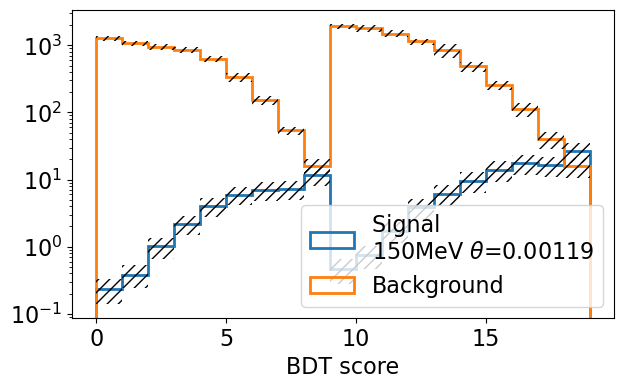

In [13]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,4),facecolor='white',dpi=100)

num_bins = len(Total_dict[HNL_mass]["BKG_dict"])

bins = np.arange(0,num_bins+1,1)
bins_cents=(bins[:-1]+bins[1:])/2
plt.hist(bins_cents, weights=Total_dict[HNL_mass]['SIGNAL_dict'], bins=bins, histtype="step", lw=2, label=f"Signal \n" + fr"{HNL_mass}MeV $\theta$={theta:.5f}")
plt.hist(bins_cents, weights=Total_dict[HNL_mass]['BKG_dict'],bins=bins, histtype="step",lw=2, label="Background")

bkg_up=np.append((Total_dict[HNL_mass]['BKG_dict']+np.array(Total_dict[HNL_mass]['TOT_BKG_ERR'])),(Total_dict[HNL_mass]['BKG_dict']+np.array(Total_dict[HNL_mass]['TOT_BKG_ERR']))[-1])
bkg_down=np.append((Total_dict[HNL_mass]['BKG_dict']-np.array(Total_dict[HNL_mass]['TOT_BKG_ERR'])),(Total_dict[HNL_mass]['BKG_dict']-np.array(Total_dict[HNL_mass]['TOT_BKG_ERR']))[-1])
sig_up=np.append((Total_dict[HNL_mass]['SIGNAL_dict']+np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict[HNL_mass]['SIGNAL_dict']+np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR']))[-1])
sig_down=np.append((Total_dict[HNL_mass]['SIGNAL_dict']-np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict[HNL_mass]['SIGNAL_dict']-np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR']))[-1])

plt.fill_between(bins, bkg_down, bkg_up,step="post",hatch='///',alpha=0,zorder=2)
plt.fill_between(bins, sig_down, sig_up,step="post",hatch='///',alpha=0,zorder=2)

plt.yscale("log")
plt.legend()
plt.xlabel("BDT score")
plt.show()

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,4),facecolor='white',dpi=100)
theta=theta_dict_scaled_r1[HNL_mass]

Run = "run1"

num_bins = len(Total_dict_run1_scaled[HNL_mass]["BKG_dict"])

bins = np.arange(0,num_bins+1,1)
bins_cents=(bins[:-1]+bins[1:])/2
plt.hist(bins_cents, weights=Total_dict_run1_scaled[HNL_mass]['SIGNAL_dict'], bins=bins, histtype="step", lw=2, label=f"Signal \n" + fr"{HNL_mass}MeV $\theta$={theta:.5f}")
plt.hist(bins_cents, weights=Total_dict_run1_scaled[HNL_mass]['BKG_dict'],bins=bins, histtype="step",lw=2, label="Background")

bkg_up=np.append((Total_dict_run1_scaled[HNL_mass]['BKG_dict']+np.array(Total_dict_run1_scaled[HNL_mass]['TOT_BKG_ERR'])),(Total_dict_run1_scaled[HNL_mass]['BKG_dict']+np.array(Total_dict_run1_scaled[HNL_mass]['TOT_BKG_ERR']))[-1])
bkg_down=np.append((Total_dict_run1_scaled[HNL_mass]['BKG_dict']-np.array(Total_dict_run1_scaled[HNL_mass]['TOT_BKG_ERR'])),(Total_dict_run1_scaled[HNL_mass]['BKG_dict']-np.array(Total_dict_run1_scaled[HNL_mass]['TOT_BKG_ERR']))[-1])
sig_up=np.append((Total_dict_run1_scaled[HNL_mass]['SIGNAL_dict']+np.array(Total_dict_run1_scaled[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict_run1_scaled[HNL_mass]['SIGNAL_dict']+np.array(Total_dict_run1_scaled[HNL_mass]['TOT_SIGNAL_ERR']))[-1])
sig_down=np.append((Total_dict_run1_scaled[HNL_mass]['SIGNAL_dict']-np.array(Total_dict_run1_scaled[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict_run1_scaled[HNL_mass]['SIGNAL_dict']-np.array(Total_dict_run1_scaled[HNL_mass]['TOT_SIGNAL_ERR']))[-1])

plt.fill_between(bins, bkg_down, bkg_up,step="post",hatch='///',alpha=0,zorder=2)
plt.fill_between(bins, sig_down, sig_up,step="post",hatch='///',alpha=0,zorder=2)

y_max = max(Total_dict_run1_scaled[HNL_mass]['BKG_dict'])
y_min = min(Total_dict_run1_scaled[HNL_mass]['SIGNAL_dict'])
# print(y_max)
# print(y_min)

plt.yscale("log")
plt.ylim(y_min*0.5,y_max*3.0)
plt.legend(fontsize=13, loc="upper right")
plt.xlabel("BDT score")

savefig=False

if savefig == True:
    plt.savefig(f"plots/CLs_plots/Example_signal_bkg_{Run}_{HNL_mass}MeV.pdf")
    plt.savefig(f"plots/CLs_plots/Example_signal_bkg_{Run}_{HNL_mass}MeV.png")


## Creating model (only do once happy with scaling)

In [17]:
if scaled==False:
    print("Using unscaled hists")
    Total_dict, theta_dict_scaled = Total_dict_both, theta_dict

model_dict_both = create_model_dict_same(Total_dict)
model_dict_split = create_model_dict_split(Total_dict_both)
model_dict_run1 = create_model_dict_same(Total_dict_run1_scaled)
# model_dict_run3 = create_model_dict(Total_dict_run3)
print("Created models")

Created models


In [18]:
print(theta_dict_scaled_r1)
print(theta_dict_scaled)

{2: 0.8408964277840475, 10: 0.09999999776482582, 20: 0.021147424734582383, 50: 0.004728707925558666, 100: 0.0031622775802825263, 150: 0.001495348743445533}
{2: 0.8408964277840475, 10: 0.06687402900289113, 20: 0.026591478812967667, 50: 0.006687402880826209, 100: 0.0021147424734582385, 150: 0.0011892070849608223}


## Making uncertainty breakdown

In [19]:
HNL_mass = 10
hist_dict_run3[HNL_mass].keys()
Uncertainties_list = ["Statistics", "Detector", r"$\nu$ Flux", r"$\nu$ Cross-section", "Reinteractions", "Dirt normalization", "Flux rate", "Total"]
Unc_colors = {"Statistics":"black", "Detector":"C1", r"$\nu$ Flux":"C2", r"$\nu$ Cross-section":"C3",
              "Reinteractions":"C4", "Dirt normalization":"C5", "Flux rate":"C2", "Total":"gray"}

In [20]:
def make_bins_dicts(hist_dict):
    """
    Given a histogram dict returns the bins and bin centres dictionaries.
    """
    bins_dict, bins_cents_dict = {}, {}
    for HNL_mass in hist_dict:
        bins = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[1]
        bin_cents = (bins[:-1]+bins[1:])/2
        bins_dict[HNL_mass] = bins
        bins_cents_dict[HNL_mass] = bin_cents
    return bins_dict, bins_cents_dict
    
bins_dict_r1, bins_cent_dict_r1 = make_bins_dicts(hist_dict_run1)
bins_dict_r3, bins_cent_dict_r3 = make_bins_dicts(hist_dict_run3)

bins_overflow_r1, bins_cents_overflow_r1 = Functions.make_overflow_bin(bins_dict_r1, bins_cent_dict_r1)
bins_overflow_r3, bins_cents_overflow_r3 = Functions.make_overflow_bin(bins_dict_r3, bins_cent_dict_r3)


In [21]:
def plot_bkg_total_unc_contributions(hist_dict, bins_dict, bins_cent_dict, Unc_colors, Run, plot_total=False, savefigs=False):
    uncs_frac_dict = {}
    for HNL_mass in hist_dict:
        plt.figure(figsize=(7,4),facecolor='white',dpi=100)
        unc_fracs = {}
        bins = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[1]
        bin_cents = (bins[:-1]+bins[1:])/2
        tot_bkg = hist_dict[HNL_mass]['bkg_overlay'].values()+hist_dict[HNL_mass]['bkg_dirt'].values()+hist_dict[HNL_mass]['bkg_EXT'].values()
        
        overlay_stat_err=hist_dict[HNL_mass]['bkg_overlay'].errors()
        dirt_stat_err=hist_dict[HNL_mass]['bkg_dirt'].errors()
        EXT_stat_err=hist_dict[HNL_mass]['bkg_EXT'].errors()
        
        bkg_stat_err_tot=Functions.add_all_errors([overlay_stat_err,dirt_stat_err,EXT_stat_err])
        
        unc_fracs["Statistics"] = np.divide(bkg_stat_err_tot,tot_bkg)
        
        unc_fracs[r"$\nu$ Flux"] = np.divide(hist_dict[HNL_mass]['ppfx_uncertainty'].values(),tot_bkg)
        unc_fracs[r"$\nu$ Cross-section"] = np.divide(hist_dict[HNL_mass]['Genie_uncertainty'].values(),tot_bkg)
        unc_fracs["Reinteractions"] = np.divide(hist_dict[HNL_mass]['Reinteraction_uncertainty'].values(),tot_bkg)
        
        unc_fracs["Detector"] = np.divide(hist_dict[HNL_mass]['overlay_DetVar_uncertainty'].values(),tot_bkg)
        
        unc_fracs["Dirt normalization"] = np.divide(hist_dict[HNL_mass]['bkg_dirt'].values(),tot_bkg)
        
        all_fracs = []        
        for unc in unc_fracs:
            plt.hist(bins_cent_dict[HNL_mass], weights=unc_fracs[unc]*100, bins=bins_dict[HNL_mass], histtype="step",
                     lw=2, label=unc, color = Unc_colors[unc])
            all_fracs.append(unc_fracs[unc])
            
        tot_frac = Functions.add_all_errors(all_fracs)
        
        if plot_total==True:
            plt.hist(bins_cent_dict[HNL_mass], weights=tot_frac*100, bins=bins_dict[HNL_mass], histtype="step",
                     lw=2, label="Quadrature sum", color = Unc_colors["Total"], linestyle="dashed")
            
        plt.xlabel('BDT score', fontsize=24)
        plt.ylabel('% Uncertainty', fontsize=24)
        plt.ylim([0,50])
        plt.legend(fontsize=10, loc="upper center")
        plt.tight_layout()
        if savefigs == True:
            plt.savefig(f"plots/BDT_output/Uncertainty_breakdown/Fractional_bkg_uncertainties_{Run}_{HNL_mass}MeV.pdf")
            plt.savefig(f"plots/BDT_output/Uncertainty_breakdown/Fractional_bkg_uncertainties_{Run}_{HNL_mass}MeV.png")
        plt.show()
            
def plot_signal_total_unc_contributions(hist_dict, bins_dict, bins_cent_dict, Unc_colors, Run, KDAR_unc, plot_total=False, savefigs=False):
    uncs_frac_dict = {}
    for HNL_mass in hist_dict:
        plt.figure(figsize=(7,4),facecolor='white',dpi=100)
        
        unc_fracs = {}
        bins = hist_dict[HNL_mass]['signal'].to_numpy()[1]
        bin_cents = (bins[:-1]+bins[1:])/2
        tot_signal = hist_dict[HNL_mass]['signal'].values()
        
        stat_err=hist_dict[HNL_mass]['signal'].errors()
        
        unc_fracs["Statistics"] = np.divide(stat_err, tot_signal)
        unc_fracs["Detector"] = np.divide(hist_dict[HNL_mass]['signal_DetVar_uncertainty'].values(), tot_signal)
        unc_fracs["Flux rate"] = np.ones(len(hist_dict[HNL_mass]['signal'].values()))*KDAR_unc 
        
        all_fracs = []        
        for unc in unc_fracs:
            plt.hist(bins_cent_dict[HNL_mass], weights=unc_fracs[unc]*100, bins=bins_dict[HNL_mass], histtype="step",
                     lw=2, label=unc, color = Unc_colors[unc])
            all_fracs.append(unc_fracs[unc])
            
        tot_frac = Functions.add_all_errors(all_fracs)
        
        if plot_total==True:
            plt.hist(bins_cent_dict[HNL_mass], weights=tot_frac*100, bins=bins_dict[HNL_mass], histtype="step",
                     lw=2, label="Quadrature sum", color = Unc_colors["Total"], linestyle="dashed")
        
        plt.xlabel('BDT score', fontsize=24)
        plt.ylabel('% Uncertainty', fontsize=24)
        plt.ylim([0,60])
        plt.legend(fontsize=10, loc="upper center")
        plt.tight_layout()
        if savefigs == True:
            plt.savefig(f"plots/BDT_output/Uncertainty_breakdown/Fractional_signal_uncertainties_{Run}_{HNL_mass}MeV.pdf")
            plt.savefig(f"plots/BDT_output/Uncertainty_breakdown/Fractional_signal_uncertainties_{Run}_{HNL_mass}MeV.png")
        plt.show()
            

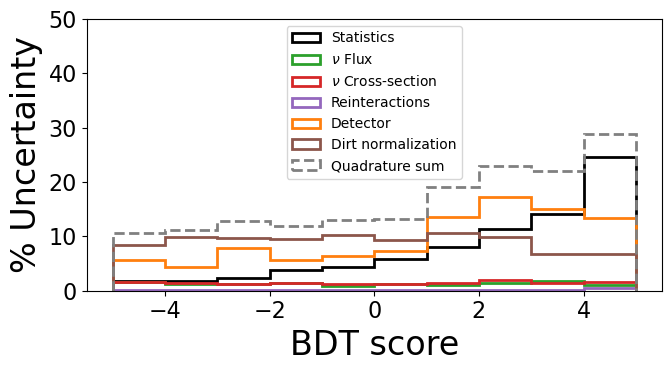

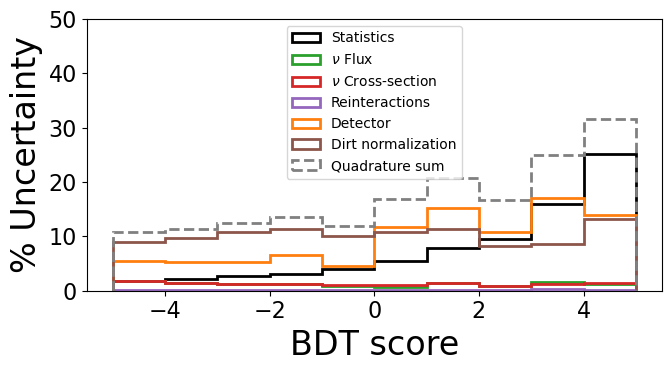

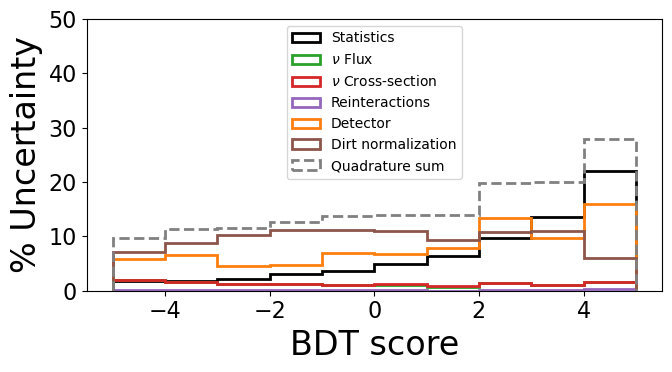

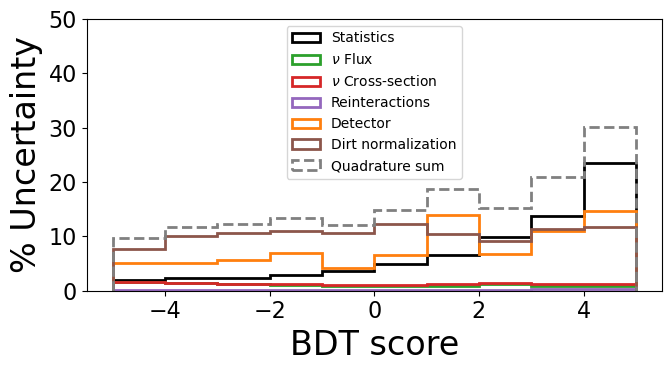

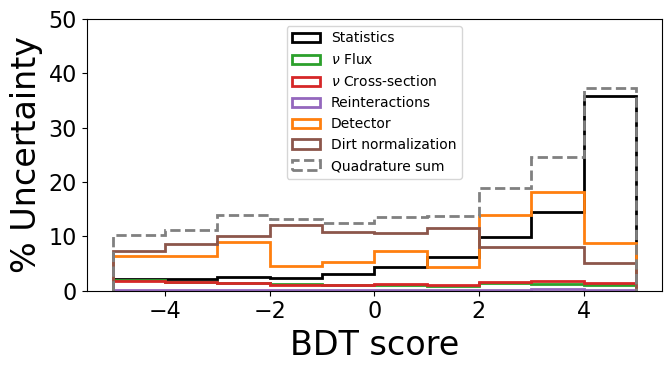

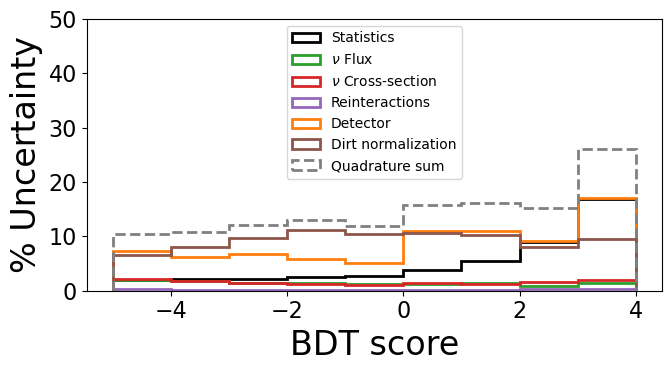

In [22]:
Run = "run1"
if Run == "run1": hist_dict, bins_overflow, bins_cents = hist_dict_run1, bins_overflow_r1, bins_cents_overflow_r1
if Run == "run3": hist_dict, bins_overflow, bins_cents = hist_dict_run3, bins_overflow_r3, bins_cents_overflow_r3

plot_bkg_total_unc_contributions(hist_dict, bins_overflow, bins_cents, Unc_colors, Run=Run, plot_total=True, savefigs=False)


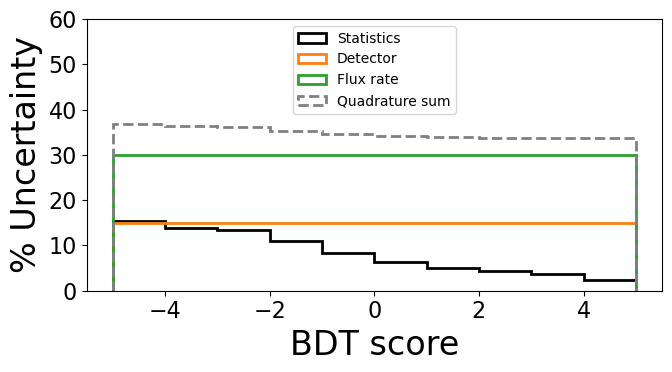

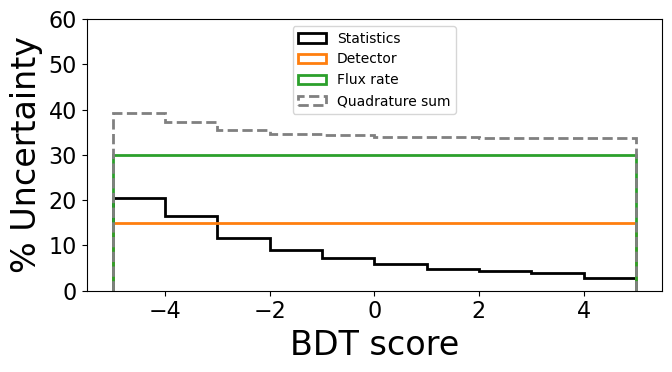

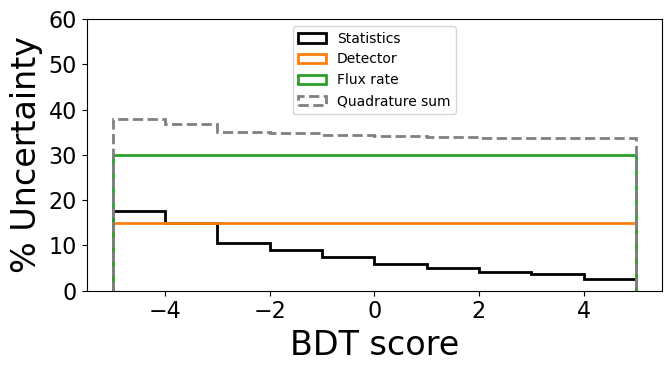

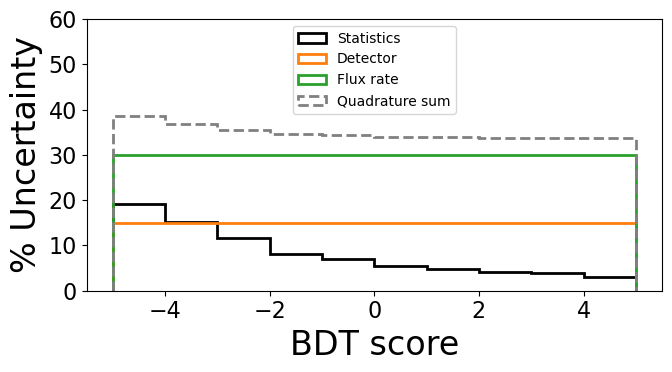

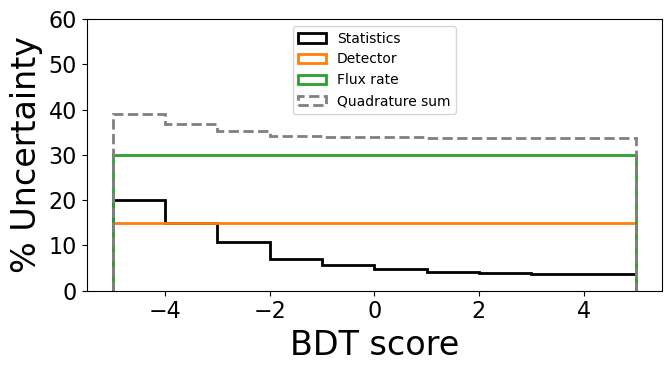

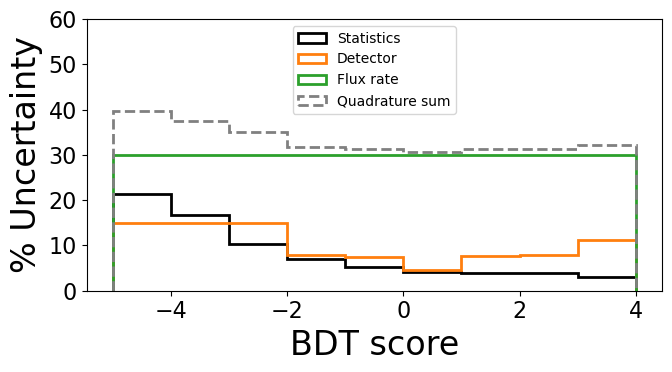

In [23]:
plot_signal_total_unc_contributions(hist_dict, bins_overflow, bins_cents, Unc_colors, Run=Run, KDAR_unc=Params_pyhf["Signal_flux_error"], plot_total=True, savefigs=False)


## Testing MLE etc.

In [ ]:
HNL_mass = 10

model_bkg = pyhf.Model(
    {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "background",
                        # "name": "signal",
                        "data": Total_dict_run1_scaled[HNL_mass]["BKG_dict"],
                        "modifiers": [
                            {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"]}
                        ],
                    }
                ],
            }
        ]
    },
    poi_name=None,
)

up_error = np.array(Total_dict_run1_scaled[HNL_mass]["BKG_dict"])+np.array(Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"]) 
down_error = np.array(Total_dict_run1_scaled[HNL_mass]["BKG_dict"])-np.array(Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"])

model_bkg_corr = pyhf.Model(
    {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "background",
                        # "name": "signal",
                        "data": Total_dict_run1_scaled[HNL_mass]["BKG_dict"],
                        "modifiers": [
                            {"name": "corr_bkguncrt", "type": "histosys", "data": {"hi_data": list(up_error), "lo_data": list(down_error)}}
                        ],
                    }
                ],
            }
        ]
    },
    poi_name=None,
)

model_bkg_norm = pyhf.Model(
    {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "background",
                        "data": Total_dict_run1_scaled[HNL_mass]["BKG_dict"],
                        "modifiers": [
                            {"name": "norm_bkguncrt", "type": "normsys", "data": {"hi": 1.25, "lo": 0.75}}
                        ],
                    }
                ],
            }
        ]
    },
    poi_name=None,
)

#----"shapesys"----#
data = Total_dict_run1_scaled[HNL_mass]["data"]+model_bkg.config.auxdata
parameters = model_bkg.config.suggested_init()
#----"histosys"----#
corr_data = Total_dict_run1_scaled[HNL_mass]["data"]+model_bkg_corr.config.auxdata
corr_data_edited = list(np.array(Total_dict_run1_scaled[HNL_mass]["data"])*0.7)+model_bkg_corr.config.auxdata
corr_parameters = model_bkg_corr.config.suggested_init()
#----"normsys"----#
norm_data = Total_dict_run1_scaled[HNL_mass]["data"]+model_bkg_norm.config.auxdata
norm_parameters = model_bkg_norm.config.suggested_init()

# print(json.dumps(model_bkg.spec, indent=2))
print(f"aux data: {model_bkg.config.auxdata}")
print(f"nominal: {model_bkg.expected_data(parameters)}")
print(f'Parameters:\n {model_bkg.config.parameters}')
print(f'Modifiers:\n {model_bkg.config.modifiers}')

best_fit, twice_nll = pyhf.infer.mle.fit(data, model_bkg,return_fitted_val=True)
best_fit_corr, twice_nll_corr = pyhf.infer.mle.fit(corr_data, model_bkg_corr,return_fitted_val=True) 
# best_fit_corr_edited, twice_nll_corr_edited = pyhf.infer.mle.fit(corr_data_edited, model_bkg_corr,return_fitted_val=True)
best_fit_norm, twice_nll_norm = pyhf.infer.mle.fit(norm_data, model_bkg_norm,return_fitted_val=True) 

print("best_fit:")
print(best_fit)
print("Twice NLL:")
print(twice_nll)


In [ ]:
#----"histosys"----#
print("----histosys----")
print(f"aux data: {model_bkg_corr.config.auxdata}")
print(f"nominal: {model_bkg_corr.expected_data(corr_parameters)}")
print(f'Parameters:\n {model_bkg_corr.config.parameters}')
print(f'Modifiers:\n {model_bkg_corr.config.modifiers}')

print(best_fit_corr)
print("Twice NLL:")
print(twice_nll_corr)

#----"normsys"----#
print()
print("----normsys----")
print(f"aux data: {model_bkg_norm.config.auxdata}")
print(f"nominal: {model_bkg_norm.expected_data(corr_parameters)}")
print(f'Parameters:\n {model_bkg_norm.config.parameters}')
print(f'Modifiers:\n {model_bkg_norm.config.modifiers}')

print(best_fit_norm)
print("Twice NLL:")
print(twice_nll_norm)

In [ ]:
upvals = np.append(up_error, [0])
downvals = np.append(down_error, [0])

#----"shapesys"----#
bkg_times_mle = np.multiply(Total_dict_run1_scaled[HNL_mass]["BKG_dict"],best_fit)

plt.hist(bins_cents[HNL_mass], weights=Total_dict_run1_scaled[HNL_mass]["BKG_dict"], bins=bins_overflow[HNL_mass], histtype="step", lw=2, label="Bkg prediction")
plt.errorbar(bins_cents[HNL_mass],Total_dict_run1_scaled[HNL_mass]["data"],fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label="Data")
plt.hist(bins_cents[HNL_mass], weights=bkg_times_mle, bins=bins_overflow[HNL_mass], histtype="step", lw=2, label="Uncorrelated best fit")
#add errors
plt.fill_between(bins_overflow[HNL_mass], downvals, upvals, step="post",color="grey",alpha=0.2,zorder=2)

#add NLLR
plt.text(0, 800, r"$-2\ln (\lambda) = $"+str(np.round(twice_nll,1)), fontsize=18)

plt.xlabel('BDT score', fontsize=24)
plt.ylabel('Events', fontsize=24)
plt.legend(fontsize=16, loc="upper right")
plt.tight_layout()

savefig = True

if savefig == True:
    plt.savefig(f"plots/CLs_plots/MLE_best_fit_bkg_uncorrelated.pdf")
    plt.savefig(f"plots/CLs_plots/MLE_best_fit_bkg_uncorrelated.png")


In [ ]:
#----"histosys"----#
corr_bkg_times_mle = np.multiply(Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"],best_fit_corr)+Total_dict_run1_scaled[HNL_mass]["BKG_dict"]

plt.hist(bins_cents[HNL_mass], weights=Total_dict_run1_scaled[HNL_mass]["BKG_dict"], bins=bins_overflow[HNL_mass], histtype="step", lw=2, label="Bkg prediction")
plt.errorbar(bins_cents[HNL_mass],Total_dict_run1_scaled[HNL_mass]["data"],fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label="Data")
plt.hist(bins_cents[HNL_mass], weights=corr_bkg_times_mle, bins=bins_overflow[HNL_mass], histtype="step", lw=2, label="Correlated best fit")
#add errors
plt.fill_between(bins_overflow[HNL_mass], downvals, upvals, step="post",color="grey",alpha=0.2,zorder=2)

plt.text(0, 800, r"$-2\ln (\lambda) = $"+str(np.round(twice_nll_corr,1)), fontsize=18)

plt.xlabel('BDT score', fontsize=24)
plt.ylabel('Events', fontsize=24)
plt.legend(fontsize=16, loc="upper right")
plt.tight_layout()

savefig = True

if savefig == True:
    plt.savefig(f"plots/CLs_plots/MLE_best_fit_bkg_correlated.pdf")
    plt.savefig(f"plots/CLs_plots/MLE_best_fit_bkg_correlated.png")


In [ ]:
print(bkg_times_mle)
print(np.array(Total_dict_run1_scaled[HNL_mass]["data"]))

In [ ]:
help(model_dict_run1[HNL_mass].logpdf)

In [ ]:
HNL_mass = 10

data = Total_dict_run1_scaled[HNL_mass]["data"]+model_dict_run1[HNL_mass].config.auxdata
parameters = model_dict_run1[HNL_mass].config.suggested_init()

best_fit, twice_nll = pyhf.infer.mle.fit(data, model_dict_run1[HNL_mass],return_fitted_val=True)
twice_nll_fit = pyhf.infer.mle.twice_nll(parameters, data, model_dict_run1[HNL_mass])

logpdf = model_dict_run1[HNL_mass].logpdf(best_fit, data)

print("best_fit:")
print(best_fit)
print("Twice NLL fit:")
print(twice_nll)
print(twice_nll_fit)
print("logpdf:")
print(logpdf)

In [ ]:
model_to_explore = model_dict_split[HNL_mass]

print(f'Samples:\n {model_to_explore.config.samples}')
print(f'Parameters:\n {model_to_explore.config.parameters}')
print(f'Modifiers:\n {model_to_explore.config.modifiers}')
print()

print(len(model_to_explore.config.auxdata))
print(model_to_explore.config.auxdata)
print(model_to_explore.config.poi_index)  
print(model_to_explore.config.suggested_bounds()) 
print(model_to_explore.config.channel_nbins)

# print(json.dumps(model_to_explore.spec, indent=2))

In [ ]:
CLs_obs, p_values = pyhf.infer.hypotest(
    test_mu, data, model, test_stat="qtilde", return_tail_probs=True
)
print(f"Observed CL_s: {CLs_obs}, CL_sb: {p_values[0]}, CL_b: {p_values[1]}")


## Making test statistic plots

In [ ]:
# Making the model with signal and bkg
HNL_mass = 10

model_full_uncorr = pyhf.Model(
    {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": Total_dict_run1_scaled[HNL_mass]["SIGNAL_dict"],
          "modifiers": [
            {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
            {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict_run1_scaled[HNL_mass]["TOT_SIGNAL_ERR"]} #Quadsum of ALL uncertainties
          ]
        },
        {
          "name": "background",
          "data": Total_dict_run1_scaled[HNL_mass]["BKG_dict"],
          "modifiers": [
            {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"]} #Quadsum of ALL uncertainties
          ]
        }
      ]
    }
  ]
}
)

sig_up = np.array(Total_dict_run1_scaled[HNL_mass]["SIGNAL_dict"])+np.array(Total_dict_run1_scaled[HNL_mass]["TOT_SIGNAL_ERR"])
sig_down = np.array(Total_dict_run1_scaled[HNL_mass]["SIGNAL_dict"])-np.array(Total_dict_run1_scaled[HNL_mass]["TOT_SIGNAL_ERR"])
bkg_up = np.array(Total_dict_run1_scaled[HNL_mass]["BKG_dict"])+np.array(Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"]) 
bkg_down = np.array(Total_dict_run1_scaled[HNL_mass]["BKG_dict"])-np.array(Total_dict_run1_scaled[HNL_mass]["TOT_BKG_ERR"])

model_full_corr = pyhf.Model(
    {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                {
                  "name": "signal",
                  "data": Total_dict_run1_scaled[HNL_mass]["SIGNAL_dict"],
                  "modifiers": [
                    {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                    {"name": "corr_siguncrt", "type": "histosys", "data": {"hi_data": list(sig_up), "lo_data": list(sig_down)}} 
                  ]
                    },
                    {
                    "name": "background",
                    "data": Total_dict_run1_scaled[HNL_mass]["BKG_dict"],
                    "modifiers": [
                        {"name": "corr_bkguncrt", "type": "histosys", "data": {"hi_data": list(bkg_up), "lo_data": list(bkg_down)}} #This is dodgy as includes stat.
                        ],
                    }
                ],
            }
        ]
    }
)


In [ ]:
HNL_mass = 10 #Mass point to test

obs_scaling = 0.2913938580237639
exp_scaling = 0.3709444625002695

Use_fully_uncorrelated = True

if Use_fully_uncorrelated == True: model_test = model_full_uncorr
if Use_fully_uncorrelated == False: model_test = model_full_corr

DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_test.config.suggested_init()
# model_test.expected_actualdata(init_pars) #signal plus bkg expected data

bkg_pars = init_pars.copy()
# bkg_pars = model_full_uncorr_no_signal.config.suggested_init()
bkg_pars[model_test.config.poi_index] = 0 #mu must be zero for the bkg-only model

# for i in range(11,21): #Setting siguncrt to 0
#     bkg_pars[i] = 0.0
    
# model_test.expected_actualdata(bkg_pars) #bkg only

print(list(zip(model_test.config.parameters, init_pars)))
print(list(zip(model_test.config.parameters, bkg_pars)))

pdf_sig = model_test.make_pdf(pyhf.tensorlib.astensor(init_pars)) #Making the pdfs
pdf_bkg = model_test.make_pdf(pyhf.tensorlib.astensor(bkg_pars)) #Making the pdfs


In [ ]:
print(bkg_pars)
# print(model_test.config.par_order)

# print(model_test.config.param_set('uncorr_siguncrt').n_parameters)

# print(model_test.config.suggested_init())
# print(model_test.config.suggested_fixed())
# bkg_pars[model_test.config.poi_index] = 0
# for i in range(11,21):
#     bkg_pars[i] = 0.0
print("Expected data given init pars")
print(model_test.expected_data(init_pars)) #should this be bkg_pars?
print("Expected data given bkg pars")
print(model_test.expected_data(bkg_pars)) #should this be bkg_pars?

print(Total_dict_run1_scaled[HNL_mass]['data']+model_test.config.auxdata)

In [ ]:
n_samples = 1000

# mu' = 0
mc_bkg = pdf_bkg.sample((n_samples,))
# mu' = 1
mc_sig = pdf_sig.sample((n_samples,))

print(mc_bkg.shape)
print(mc_sig.shape)

In [ ]:
toy_calculator_qtilde_data = pyhf.infer.utils.create_calculator( #only seems to support q-like test statistics
    "toybased",
    # model_test.expected_data(init_pars),
    Total_dict_run1_scaled[HNL_mass]['data']+model_test.config.auxdata,
    model_test,
    ntoys=n_samples,
    test_stat="qtilde",
)
toy_calculator_qtilde_exp = pyhf.infer.utils.create_calculator( #only seems to support q-like test statistics
    "toybased",
    model_test.expected_data(bkg_pars),
    # Total_dict_run1_scaled[HNL_mass]['data']+model_test.config.auxdata,
    model_test,
    ntoys=n_samples,
    test_stat="qtilde",
)

print("mu = 1 distributions")
# qtilde_sig, qtilde_bkg = toy_calculator_qtilde.distributions(1.0) #1.0 for full signal contribution, "null" defaults to mu=1 in pyhf
qtilde_sig_obs, qtilde_bkg_obs = toy_calculator_qtilde_data.distributions(obs_scaling) 
qtilde_sig_exp, qtilde_bkg_exp = toy_calculator_qtilde_exp.distributions(exp_scaling) 


In [ ]:
#small p-value means outcome v unlikely under null hypothesis
# print(qtilde_sig.pvalue(2.0))
# print(qtilde_sig.pvalue(1.0))
# print(qtilde_sig.pvalue(0.5))
# print(qtilde_sig.pvalue(0.1))
# print()
# print(qtilde_bkg.pvalue(2.0))
# print(qtilde_bkg.pvalue(1.0))
# print(qtilde_bkg.pvalue(0.5))
# print(qtilde_bkg.pvalue(0.1))
# print()

CLsb, CLb, CLs = toy_calculator_qtilde_exp.expected_pvalues(qtilde_sig_exp, qtilde_bkg_exp)
print("Expected")
print("CLsb " + str(CLsb[2]))
print("CLb " + str(CLb[2]))
print("CLs " + str(CLs[2]))
print(CLsb[2]/CLb[2])

In [ ]:
q_tilde_obs = toy_calculator_qtilde_data.teststatistic(obs_scaling)

CLsb_obs, CLb_obs, CLs_obs = toy_calculator_qtilde_data.pvalues(q_tilde_obs, qtilde_sig_obs, qtilde_bkg_obs)
print("Observed")
print("qtilde sig " + str(q_tilde_obs))
print("CLsb " + str(CLsb_obs))
print("CLb " + str(CLb_obs))
print("CLs " + str(CLs_obs))

print(CLsb_obs/CLb_obs)

In [ ]:
data = Total_dict_run1_scaled[HNL_mass]["data"]+model_test.config.auxdata
data_exp = model_test.expected_data(bkg_pars)
par_bounds = model_test.config.suggested_bounds()
fixed_params = model_test.config.suggested_fixed()

# q0 = pyhf.infer.test_statistics.q0(0, data, model_test, init_pars, par_bounds, fixed_params, return_fitted_pars=True)
# tmu_tilde = pyhf.infer.test_statistics.tmu_tilde(1.0, data, model_test, init_pars, par_bounds, fixed_params, return_fitted_pars=True)

qmu_tilde_obs = pyhf.infer.test_statistics.qmu_tilde(obs_scaling, data, model_test, init_pars, par_bounds, fixed_params, return_fitted_pars=False)
qmu_tilde_exp = pyhf.infer.test_statistics.qmu_tilde(exp_scaling, data_exp, model_test, init_pars, par_bounds, fixed_params, return_fitted_pars=False)


In [ ]:
# print(q0)
# print(tmu_tilde)

print(qmu_tilde_obs)
print(q_tilde_obs)
print(qmu_tilde_exp)

# help(pyhf.infer.test_statistics.tmu_tilde)

# emp_dist = pyhf.infer.calculators.EmpiricalDistribution(samples)

# help(pyhf.infer.test_statistics) #tmu, tmu_tilde

# help(toy_calculator_qtilde.distributions)

def Get_proportion(dist, test_stat_val):
    """
    Given a pyhf sample "dist" and a given value, 
    returns the proportion of the total dist up to that point.
    """
    if max(dist) < test_stat_val:
        print("Value is above max in dist")
        return 0
    ordered_test_stat = np.sort(dist) #Test stat vals going from lowest to highest
    itemindex = np.where(ordered_test_stat >= test_stat_val)
    prop = itemindex[0][0]/len(dist)
    
    return prop


In [ ]:
p_val_b = Get_proportion(qtilde_bkg_obs.samples, qmu_tilde_obs) #Integral of b-only dist where test stat < observed val
p_val_sb = 1-Get_proportion(qtilde_sig_obs.samples, qmu_tilde_obs) #Integral of s+b dist where test stat > observed val
print("Observed")
print("p_b: " + str(p_val_b))
print("p_sb: " + str(p_val_sb))

print(p_val_sb/(1-p_val_b))

p_val_b_exp = Get_proportion(qtilde_bkg_exp.samples, qmu_tilde_exp) 
p_val_sb_exp = 1-Get_proportion(qtilde_sig_exp.samples, qmu_tilde_exp)

print()
print("Expected")
print("p_b: " + str(p_val_b_exp))
print("p_sb: " + str(p_val_sb_exp))

print(p_val_sb_exp/(1-p_val_b_exp))

In [ ]:
print("Max qtilde signal value: " + str(max(qtilde_sig_obs.samples)))
print("Max qtilde background value: " + str(max(qtilde_bkg_obs.samples)))

#Finding probability for one value of test statistic
ordered_test_stat = np.sort(qtilde_sig_obs.samples)
ordered_bkg = np.sort(qtilde_bkg_obs.samples)
length =len(ordered_test_stat)

prob = 0.9
slice_at = 0.9*length
print("-----signal-----")
print(np.floor(slice_at))
print(ordered_test_stat[int(slice_at)])
value_for_prob = ordered_test_stat[int(slice_at)]

print("-----bkg-----")
print(np.floor(slice_at))
print(ordered_bkg[int(slice_at)])
bkg_expected_qtilde = ordered_bkg[int(0.5*length)]
print(bkg_expected_qtilde)

In [ ]:
#unedited one cell below
savefig=True

# x_max = max(qtilde_sig.samples)
x_max = max(qtilde_bkg_obs.samples)
# x_max=2e-8
print(x_max)

plt.figure(figsize=(10, 6))
nbins = 30 #Should make an array for the bin edges
bins = np.linspace(0,x_max*1.2,nbins) #was 0, 45 before

hist, edges = np.histogram(qtilde_sig_obs.samples, bins=bins, density=True)
edges = np.repeat(edges, 2)
hist = np.hstack((0, np.repeat(hist, 2), 0))

hist_bkg, edges_bkg = np.histogram(qtilde_bkg_obs.samples, bins=bins, density=True)
edges_bkg = np.repeat(edges_bkg, 2)
hist_bkg = np.hstack((0, np.repeat(hist_bkg, 2), 0))

hatch_from= qmu_tilde_obs
hatch_from_bkg= 0.0
print(qmu_tilde_obs)
hatch_till= 15
hatch_till_bkg= qmu_tilde_obs

fill_region = (hatch_from<edges)&(edges<hatch_till)

fill_region_bkg = (hatch_from_bkg<edges_bkg)&(edges_bkg<hatch_till_bkg)
test_fill_bkg = hist_bkg[fill_region_bkg].copy()
# test_fill_bkg[-1] = 0.0
new_hist=np.append(test_fill_bkg, test_fill_bkg[-1])
new_hist=np.append(new_hist, 0.0)

test_fill_edges = edges_bkg[fill_region_bkg].copy()
new_edges=np.append(test_fill_edges, qmu_tilde_obs)
new_edges=np.append(new_edges, qmu_tilde_obs)


plt.hist(
    qtilde_sig_obs.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|1)$ signal-like",
    color="#D62728",
    linewidth=2,
)
plt.hist(
    qtilde_bkg_obs.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    color="#1F77B4",
    linewidth=2,
)

plt.fill_betweenx(hist[fill_region], 
                  edges[fill_region], qmu_tilde_obs,
                  color='none', edgecolor='#D62728',
                  hatch='xxx', label=r"$p_b$")

plt.fill_betweenx(new_hist, 
                  new_edges, 0,
                  color='none', edgecolor='#1F77B4',
                  hatch='xxx', label=r"$p_{sb}$")

if Use_fully_uncorrelated == True: model_name = "fully_uncorrelated"
if Use_fully_uncorrelated == False: model_name = "correlated"

plt.axvline(x = qmu_tilde_obs, color = 'black', label = r'Data',linestyle="dashed", lw=3)
# plt.axvline(x = bkg_expected_qtilde, color = 'gray', label = 'Background expectation',linestyle="dashed", lw=3)

plt.xlabel(r"$\tilde{q}_1$", fontsize=22)
plt.ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=22)

plt.yscale("log")
plt.ylim(3e-3, 2.0)
plt.xlim(0,15)
plt.legend(fontsize=20)
plt.tight_layout()

if savefig==True:
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_obs_{model_name}_{HNL_mass}MeV.pdf")
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_obs_{model_name}_{HNL_mass}MeV.png")

In [ ]:
savefig=False

# x_max = max(qtilde_sig.samples)
x_max = max(qtilde_bkg_obs.samples)
# x_max=2e-8

plt.figure(figsize=(10, 6))
nbins = 30 #Should make an array for the bin edges
bins = np.linspace(0,x_max*1.2,nbins) #was 0, 45 before



plt.hist(
    qtilde_sig_obs.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qtilde_bkg_obs.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    linewidth=2,
)
# value_for_prob = 2.16
if Use_fully_uncorrelated == True: model_name = "fully_uncorrelated"
if Use_fully_uncorrelated == False: model_name = "correlated"

# plt.axvline(x = value_for_prob, color = 'red', label = '90% signal-like',linestyle="dashed", lw=3)
plt.axvline(x = qmu_tilde_obs, color = 'black', label = 'Data',linestyle="dashed", lw=3)
plt.axvline(x = bkg_expected_qtilde, color = 'gray', label = 'Background expectation',linestyle="dashed", lw=3)

plt.xlabel(r"$\tilde{q}_1$", fontsize=22)
plt.ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=22)

plt.yscale("log")
plt.ylim(3e-3, 2.0)
plt.legend(fontsize=20)
plt.tight_layout()

if savefig==True:
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_obs_{model_name}_{HNL_mass}MeV.pdf")
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_obs_{model_name}_{HNL_mass}MeV.png")

In [ ]:
#All just zeros, I don't fully understand this way. 
savefig=False

# x_max = max(qtilde_sig.samples)
x_max = max(qtilde_sig_q0.samples)
# x_max=2e-8

plt.figure(figsize=(10, 6))
nbins = 30 #Should make an array for the bin edges
bins = np.linspace(0,x_max*1.2,nbins) #was 0, 45 before
plt.hist(
    qtilde_sig_q0.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_0|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qtilde_bkg_q0.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_0|0)$ background-like",
    linewidth=2,
)
# value_for_prob = 2.16
if Use_fully_uncorrelated == True: model_name = "fully_uncorrelated"
if Use_fully_uncorrelated == False: model_name = "correlated"

# plt.axvline(x = value_for_prob, color = 'red', label = '90% signal-like',linestyle="dashed", lw=3)

plt.xlabel(r"$\tilde{q}_0$", fontsize=22)
plt.ylabel(r"$f\,(\tilde{q}_0|\mu')$", fontsize=22)

plt.yscale("log")
plt.legend(fontsize=22)
plt.tight_layout()

if savefig==True:
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_0_{model_name}_{HNL_mass}MeV.pdf")
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_0_{model_name}_{HNL_mass}MeV.png")

In [ ]:
qmu_bounds = model_test.config.suggested_bounds()
print(f"Old bounds: {qmu_bounds}")
# qmu_bounds[model_dict[HNL_mass].config.poi_index] = (-10, 10) #Made these larger and didn't get minimization error in followin cell
qmu_bounds[model_test.config.poi_index] = (-50, 50)
print(f"New bounds: {qmu_bounds}")


In [ ]:
toy_calculator_qmu = pyhf.infer.utils.create_calculator(
    "toybased",
    model_test.expected_data(model_test.config.suggested_init()),
    model_test,
    par_bounds=qmu_bounds,
    ntoys=n_samples,
    test_stat="q",
)
qmu_sig, qmu_bkg = toy_calculator_qmu.distributions(1.0)

In [ ]:
print(max(qmu_sig.samples))
print(max(qmu_bkg.samples))
print(min(qmu_sig.samples))
print(min(qmu_bkg.samples))

ordered_test_stat = np.sort(qmu_sig.samples)
length =len(ordered_test_stat)

prob = 0.9
slice_at = 0.9*length
print(np.floor(slice_at))
print(ordered_test_stat[int(slice_at)])
value_for_prob = ordered_test_stat[int(slice_at)]

In [ ]:
savefig=True

plt.figure(figsize=(10, 6))
nbins = 30 #Should make an array for the bin edges
x_max = max(qmu_bkg.samples)
x_min = min(qmu_sig.samples)
bins = np.linspace(0,x_max*1.2,nbins)
plt.hist(
    qmu_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qmu_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|0)$ background-like",
    linewidth=2,
)

plt.axvline(x = value_for_prob, color = 'red', label = '90% signal-like',linestyle="dashed", lw=3)

plt.xlabel(r"$q_1$", fontsize=18)
plt.ylabel(r"$f\,(q_1|\mu')$", fontsize=18)

plt.yscale("log")
plt.legend(fontsize=22)

plt.tight_layout()

if savefig==True:
    plt.savefig(f"plots/CLs_plots/Test_stat_q_{model_name}_{HNL_mass}MeV.pdf")
    plt.savefig(f"plots/CLs_plots/Test_stat_q_{model_name}_{HNL_mass}MeV.png")

In [ ]:
# emp_dist = pyhf.infer.calculators.EmpiricalDistribution(samples)
help(pyhf.infer.calculators.EmpiricalDistribution)
help(pyhf.infer.test_statistics) #tmu, tmu_tilde

In [ ]:
help(pyhf.infer.utils.create_calculator)

## Changing poi values

In [ ]:
def get_CL_range(observations, model,unbounded_bounds,cl):

    alpha = round(1-0.01*cl,2)
    low_end  = 1000
    high_end = 2000
    obs_limit = 2000
    iterations = 0
    delta_iter = 1000
    while obs_limit >= high_end:
        iterations += 1
        if iterations > 1:
            delta_iter = iterations*10000
            high_end   += delta_iter
        poi_values = np.linspace(low_end,high_end,3)
        obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.upper_limit(
            observations,model,poi_values,level=alpha,par_bounds=unbounded_bounds
        )
        print(iterations,"iterations")
    #return np.linspace(low_end,2*high_end,10)
    #lo_range = max(1000,obs_limit-obs_limit/2.)
    lo_range = 1000.
    if obs_limit > 10000:
        lo_range = obs_limit-obs_limit/2.
    up_range = obs_limit+obs_limit/2.
    return np.linspace(lo_range,up_range,50)


nbins = model.config.channel_nbins['singlechannel']
print("\nNumber of bins:",nbins)
print(type(nbins))

# suggested initial parameters
init_pars = model.config.suggested_init()
print("\nInitial parameters:",init_pars)
print("\nSuggested bounds:",model.config.suggested_bounds())

unbounded_bounds = model.config.suggested_bounds()
unbounded_bounds[model.config.poi_index] = (0, 160000000) #Something very large

## Testing single point

In [ ]:
model_dict_uncorr = {}
model_dict_uncorr[10] = model_full_uncorr
# model_dict_uncorr[10] = model_dict_both

In [ ]:
HNL_mass = 150 #The mass point to test
n_sigmas = 2
if n_sigmas==1: sigma_list = np.arange(-1, 2)
if n_sigmas==2: sigma_list = np.arange(-2, 3)

# model_dict_to_use = model_dict_both
# model_dict_to_use = model_dict_run1 #model_full_uncorr

# model_dict_to_use = model_dict_uncorr
model_dict_to_use = model_dict_both
# Total_dict_to_use = Total_dict_run1_scaled #Total_dict_both, Total_dict_run1, Total_dict_run3
Total_dict_to_use = Total_dict_both

DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict_to_use[HNL_mass].config.suggested_init()
model_dict_to_use[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict_to_use[HNL_mass].config.poi_index] = 0
model_dict_to_use[HNL_mass].expected_actualdata(bkg_pars) #bkg only

if 'data' not in Total_dict_to_use[HNL_mass].keys(): 
    print("No data in this sample, using bkg as data")
    DATA_OBS_dict[HNL_mass] = Total_dict_to_use[HNL_mass]["BKG_dict"]+model_dict_to_use[HNL_mass].config.auxdata
else: 
    print("Using real data for observed limit")
    DATA_OBS_dict[HNL_mass] = Total_dict_to_use[HNL_mass]["data"]+model_dict_to_use[HNL_mass].config.auxdata    

model_dict_to_use[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass]) #Is this only for the test stat distribution stuff?
    
poi_values = np.linspace(0.001, 10, 500) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(DATA_OBS_dict[HNL_mass], 
                                                                                       model_dict_to_use[HNL_mass], poi_values, 
                                                                                       level=0.1, return_results=True)
print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

In [ ]:
if Params_pyhf["Use_toys"] == True:
    CLs_obs, CLs_exp = pyhf.infer.hypotest(
            # 1.0,  # null hypothesis mu
            obs_limit_single, #mu
            # exp_limits_single[2], #mu
            DATA_OBS_dict[HNL_mass],
            model_dict_to_use[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            # ntoys=Params_pyhf["Num_toys"],
            ntoys=2000,
            # track_progress=True, 
            )
for expected_value, n_sigma in zip(CLs_exp, sigma_list): #-2, 3
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")
        

In [ ]:
print(CLs_obs)

In [ ]:
exp_limit = []
obs_limit = []
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict_scaled[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta_squared)
    obs_limit.append(LIMIT)

In [ ]:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict_scaled[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta_squared)
    obs_limit.append(LIMIT)

In [ ]:
print(obs_limit)
print("Expected limit")
print(exp_limit)
print("1 sigma up")
print(exp_1sig_up)
print("2 sigma up")
print(exp_2sig_up)
print("1 sigma down")
print(exp_1sig_down)
print("2 sigma down")
print(exp_2sig_down)

In [ ]:
print(exp_limits_single)

## Running through all points

In [24]:
# model_dict = model_dict_split #Uncertainties are split into different modifiers, takes several times longer to run.
# model_dict = model_dict_both #Quicker, uncertainties are entered as one uncertainty which is the quadsum of components.
# Total_dict = Total_dict_both

# model_dict = model_dict_run1
# Total_dict = Total_dict_run1_scaled

model_dict = model_dict_both
Total_dict = Total_dict_both

if Params_pyhf["Load_pi0_hists"]==True:HNL_masses=Constants.HNL_mass_pi0_samples
elif Params_pyhf["Load_lepton_hists"]==True:HNL_masses=Constants.HNL_mass_samples
elif Params_pyhf["Load_single_r1_file"]==True: HNL_masses = HNL_masses_list
    
# HNL_masses = HNL_masses_list

# list_test = Constants.HNL_mass_samples
print("Running for these masses: " + str(HNL_masses))

DATA_OBS_dict = {}

for HNL_mass in HNL_masses:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[HNL_mass].keys())
    if "data" in list_keys: #haven't made this yet, need to test
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
    else:
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

Running for these masses: [2, 10, 20, 50, 100, 150]


In [25]:
#Should take ~10 mins with 100 toys and 4 bins
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 5, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in HNL_masses:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended
Max value is 5.0
Min value is 0.001
Next value is 0.05149494949494949
Next value is 0.10198989898989898



/tmp/ipykernel_8099/1144089858.py:16: DeprecationWarning: pyhf.infer.intervals.upperlimit is deprecated in favor of pyhf.infer.intervals.upper_limits.upper_limit as of pyhf v0.7.0 and will be removed in pyhf v0.9.0. Please use pyhf.infer.intervals.upper_limits.upper_limit.
  obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(


Upper limit 2MeV (obs): μ = 1.732749
Upper limit 2MeV (exp): μ = 1.562581

Upper limit 10MeV (obs): μ = 1.265358
Upper limit 10MeV (exp): μ = 0.724903

Upper limit 20MeV (obs): μ = 0.312497
Upper limit 20MeV (exp): μ = 0.320535

Upper limit 50MeV (obs): μ = 0.599391
Upper limit 50MeV (exp): μ = 0.438147

Upper limit 100MeV (obs): μ = 0.845324
Upper limit 100MeV (exp): μ = 0.528452

Upper limit 150MeV (obs): μ = 0.462893
Upper limit 150MeV (exp): μ = 0.357429



In [ ]:
#Takes ~10 mins with 100 toys and 4 bins, for all errors in one modifier
for HNL_mass in HNL_masses:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            # track_progress=True, 
            # track_progress=False, #Used to have as true, but this gave an error when the signal was scaled up
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
# print((scan, results))
# print(scan)
# print(results[90])

In [26]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict_scaled[HNL_mass])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    obs_limit.append(LIMIT)
    
print(exp_limit)
print(obs_limit)
removed_2MeV = False

0.7071068022599718
Expected 2MeV limit is 0.883906472559343
Observed 2MeV limit is 0.9307924537805952

0.004472135755079524
Expected 10MeV limit is 0.0038076328002904095
Observed 10MeV limit is 0.005030621676307548

0.0007071067454605083
Expected 20MeV limit is 0.00040033416526572235
Observed 20MeV limit is 0.00039528288274345104

4.472135729048268e-05
Expected 50MeV limit is 2.960224572492681e-05
Observed 50MeV limit is 3.462342516199501e-05

4.4721357290482684e-06
Expected 100MeV limit is 3.251004965368042e-06
Observed 100MeV limit is 4.111748742201959e-06

1.4142134909210164e-06
Expected 150MeV limit is 8.454924397541505e-07
Observed 150MeV limit is 9.621774679392689e-07

[0.883906472559343, 0.0038076328002904095, 0.00040033416526572235, 2.960224572492681e-05, 3.251004965368042e-06, 8.454924397541505e-07]
[0.9307924537805952, 0.005030621676307548, 0.00039528288274345104, 3.462342516199501e-05, 4.111748742201959e-06, 9.621774679392689e-07]


In [ ]:
POT_norms = Constants.run1_POT_scaling_dict

print(POT_norms['245_pi0_dirac'])
print(POT_norms['245_pi0'])

In [ ]:
masses = HNL_masses
# limts_Maj = [0.005413019157172526,5.447736619270424e-06,1.585234277739009e-06] #ee
limts_Maj = [1.8571539668620982e-07,4.214921434135996e-08,2.217237268632437e-08] #pi0
limits_Dir = [5.378917430264621e-07, 1.2004619124764445e-07, 6.640407306572216e-08]
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

plt.plot(masses, limts_Maj, label="Maj.")
plt.plot(masses, limits_Dir, label="Dir.")
plt.yscale('log')
plt.legend()

In [ ]:
ratio_Dirac = {}
ratio_sum = 0
for i, HNL_mass in enumerate(HNL_masses):
    ratio_Dirac[HNL_mass] = limts_Maj[i]/limits_Dir[i]
    ratio_sum += ratio_Dirac[HNL_mass]
    
print(ratio_Dirac)
print(ratio_sum/3)

## Removing 2MeV point

In [27]:
reload(Constants)
if Params_pyhf["Load_lepton_hists"]==True:
    HNL_masses=Constants.HNL_mass_samples.copy()
    if removed_2MeV == False:
        print("Removing the first element in the limit and mass lists")
        exp_limit.pop(0)
        obs_limit.pop(0)
        HNL_masses.pop(0)
        exp_1sig_up.pop(0)
        exp_2sig_up.pop(0)
        exp_1sig_down.pop(0)
        exp_2sig_down.pop(0)
        print(HNL_masses)
        print(exp_limit)
        print(obs_limit)
    else: print("First element has already been removed")
    removed_2MeV = True

Removing the first element in the limit and mass lists
[10, 20, 50, 100, 150]
[0.0038076328002904095, 0.00040033416526572235, 2.960224572492681e-05, 3.251004965368042e-06, 8.454924397541505e-07]
[0.005030621676307548, 0.00039528288274345104, 3.462342516199501e-05, 4.111748742201959e-06, 9.621774679392689e-07]


## Saving limit as .csv

In [ ]:
print(exp_limit)
print(obs_limit)

In [28]:
masses = HNL_masses

if Params_pyhf["Stats_only"] == True: stats =  "Stats_only"
elif Params_pyhf["Use_flat_sys"] == True: stats = "Flat_sys"
else: stats = "Full_sys"
    
if Params_pyhf["Use_part_only"] == True: part_hist = str(Params_pyhf["Num_bins_for_calc"])+"_bins"
else: part_hist = "full_hist"

print(masses)
print(exp_limit)

filename = "_EXT_Finished.csv"

# r = zip(masses, exp_limit)
r = zip(masses, obs_limit)
q = zip(masses, exp_limit)
if Params_pyhf["Load_lepton_hists"] == True:
    savename = f'limit_files/My_limits/observed_{stats}_{part_hist}_{filename}'
    with open(savename, "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)
            
    savename_exp = f'limit_files/My_limits/expected_{stats}_{part_hist}_{filename}'
    with open(savename_exp, "w") as s:
        w = csv.writer(s)
        for row in q:
            w.writerow(row)
            
if Params_pyhf["Load_pi0_hists"] == True:
    savename = f'limit_files/My_limits/{stats}_{part_hist}_pi0_{filename}'
    with open(f'limit_files/My_limits/{stats}_{part_hist}_pi0_{filename}', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)
            
if Params_pyhf["Load_single_r1_file"] == True:
    savename = f'limit_files/My_limits/{stats}_{part_hist}_single_file_{filename}'
    with open(f'limit_files/My_limits/{stats}_{part_hist}_single_file_{filename}', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print()
print("Save name is : \'"+savename+"\'")

[10, 20, 50, 100, 150]
[0.0038076328002904095, 0.00040033416526572235, 2.960224572492681e-05, 3.251004965368042e-06, 8.454924397541505e-07]

Save name is : 'limit_files/My_limits/observed_Full_sys_full_hist__EXT_Finished.csv'


## Saving sigma bands for brazil plots

In [ ]:
save_loc = "limit_files/Brazil_plot/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

if Params_pyhf["Load_lepton_hists"] == True:decay_type = "ee"
elif Params_pyhf["Load_pi0_hists"]==True: decay_type = "pi0"
else: decay_type = "single_file"

filename=f"_{decay_type}_2_May.csv"
for i, lim in enumerate(to_save_lists):

    r = zip(masses, lim)
    savestr=to_save_names[i]
    savename = save_loc+savestr+filename
    with open(savename, "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print("Last saved is " + savename)

## Testing adjacent models

In [ ]:
adjacent_hist_dict_run1, adjacent_hist_dict_run3 = {}, {}
R1_BKG_ERR_dict_ADJ, R3_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = {}, {}, {}, {}
mass_point = 50
test_models = [20, 100]
for mass_model in test_models:
    adjacent_hist_dict_run1[mass_model] = uproot.open(f'bdt_output/adjacent_models/run1_{mass_point}MeV_{mass_model}MeV_model.root')
    adjacent_hist_dict_run3[mass_model] = uproot.open(f'bdt_output/adjacent_models/run3_{mass_point}MeV_{mass_model}MeV_model.root')
    R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run1)
    R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run3)
    # R1_BKG_ERR_dict_ADJ[mass_model]=R1_BKG_ERR_dict[mass_point]
    # R3_BKG_ERR_dict_ADJ[mass_model]=R3_BKG_ERR_dict[mass_point]
    # R1_SIGNAL_ERR_dict_ADJ[mass_model]=R1_SIGNAL_ERR_dict[mass_point]
    # R3_SIGNAL_ERR_dict_ADJ[mass_model]=R3_SIGNAL_ERR_dict[mass_point]
adjacent_hist_dict_run1[mass_point] = hist_dict_run1[mass_point]
adjacent_hist_dict_run3[mass_point] = hist_dict_run3[mass_point]
R1_BKG_ERR_dict_ADJ[mass_point]=R1_BKG_ERR_dict[mass_point]
R3_BKG_ERR_dict_ADJ[mass_point]=R3_BKG_ERR_dict[mass_point]
R1_SIGNAL_ERR_dict_ADJ[mass_point]=R1_SIGNAL_ERR_dict[mass_point]
R3_SIGNAL_ERR_dict_ADJ[mass_point]=R3_SIGNAL_ERR_dict[mass_point]

R1_BKG_ADJ, R1_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run1)
R3_BKG_ADJ, R3_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run3)

R1_output_ADJ = Functions.Make_into_lists(Params_pyhf, R1_BKG_ADJ, R1_SIGNAL_ADJ, R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ)
R3_output_ADJ = Functions.Make_into_lists(Params_pyhf, R3_BKG_ADJ, R3_SIGNAL_ADJ, R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ)

list_input_dicts_ADJ = [R1_output_ADJ, R3_output_ADJ]
# list_input_dicts = [R1_output, R1_output] #Used when I didn't have Run3

Total_dict_ADJ = Functions.Create_final_appended_runs_dict(list_input_dicts_ADJ)
print(Total_dict_ADJ[100].keys())

In [ ]:
print(Total_dict.keys())

In [ ]:
model_dict_ADJ = create_model_dict(Total_dict_ADJ)

In [ ]:
list_test = adjacent_hist_dict_run1.keys()
DATA_OBS_dict = {}

# for HNL_mass in Constants.HNL_mass_samples: #removing the 240MeV point
for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

In [ ]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict_scaled[mass_point])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

In [ ]:
points = [6.912810521978472e-06, 7.3827958770328454e-06, 1.9840221581842897e-05]
x_points = [50, 50, 50]
labels = ["correct", "20MeV", "50MeV"]
for i, point in enumerate(points):
    plt.plot(x_points[i],point,label=labels[i],marker="o")
plt.legend()

In [ ]:
rat_20 = 6.912810521978472e-06/7.3827958770328454e-06
rat_100 = 6.912810521978472e-06/1.9840221581842897e-05
print("20MeV model is " + str(rat_20))
print("100MeV model is " + str(rat_100))

## Brazil plot

In [ ]:
#Plotting ee limit
if Params_pyhf["Load_lepton_hists"]==True:
    plt.figure(figsize=(14,8),facecolor='white',dpi=100)

    savefig = False

    plt.plot(HNL_masses,np.array(obs_limit),lw=4,ls='-',color='black',label='Observed')
    plt.plot(HNL_masses,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
    plt.fill_between(HNL_masses,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
    plt.fill_between(HNL_masses,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')

    plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=22)
    plt.xlabel('HNL Mass [MeV]',fontsize=22)

    plt.ylim(5e-7,6e-3)
    plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=22)
    # plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlim(0,155)
    # plt.xlim(0,250)
    plt.yscale('log')

    plt.tight_layout()

    savename = "ee_observed"

    if savefig == True:
        plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
        plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

    plt.grid(False)


In [ ]:
#Plotting pi0 limit
if Params_pyhf["Load_pi0_hists"]==True:
    plt.figure(figsize=(14,8),facecolor='white',dpi=100)

    savefig = True

    plt.plot(HNL_masses,np.array(obs_limit),lw=5,ls='-',color='black',label='Observed')
    plt.plot(HNL_masses,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
    plt.fill_between(HNL_masses,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
    plt.fill_between(HNL_masses,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')

    plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=22)
    plt.xlabel('HNL Mass [MeV]',fontsize=22)

    plt.ylim(1e-8,3e-7)
    plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=22)
    # plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlim(140,255)
    # plt.xlim(0,250)
    plt.yscale('log')

    plt.tight_layout()

    savename = "pi0_observed"

    if savefig == True:
        plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
        plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

    plt.grid(False)

In [ ]:
#Plotting BOTH on one plot
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

savefig = False

save_loc = "limit_files/Brazil_plot/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

#ee curves
decay_type="ee"
filename=f"_{decay_type}_21_April.csv"
# for i, lim in enumerate(to_save_lists):

ee_exp_1sig_up = Functions.Pandafy_new(save_loc+"exp_1sig_up"+filename)
ee_exp_1sig_down = Functions.Pandafy_new(save_loc+"exp_1sig_down"+filename)
ee_exp_2sig_up = Functions.Pandafy_new(save_loc+"exp_2sig_up"+filename)
ee_exp_2sig_down = Functions.Pandafy_new(save_loc+"exp_2sig_down"+filename)
ee_exp_limit = Functions.Pandafy_new(save_loc+"exp_limit"+filename)
ee_obs_limit = Functions.Pandafy_new(save_loc+"obs_limit"+filename)
HNL_masses_ee = [10, 20, 50, 100, 150]

plt.plot(HNL_masses_ee,np.array(ee_obs_limit["Value"]),lw=5,ls='-',color='black')
plt.plot(HNL_masses_ee,np.array(ee_exp_limit["Value"]),lw=2,ls='--',color='red')
plt.fill_between(HNL_masses_ee,np.array(ee_exp_2sig_down["Value"]),np.array(ee_exp_2sig_up["Value"]),color='yellow')
plt.fill_between(HNL_masses_ee,np.array(ee_exp_1sig_down["Value"]),np.array(ee_exp_1sig_up["Value"]),color='lightgreen')

#pi0 curves
decay_type="pi0"
filename=f"_{decay_type}_21_April.csv"
HNL_masses_pi0 = [150, 180, 200, 220, 240, 245]

pi0_exp_1sig_up = Functions.Pandafy_new(save_loc+"exp_1sig_up"+filename)
pi0_exp_1sig_down = Functions.Pandafy_new(save_loc+"exp_1sig_down"+filename)
pi0_exp_2sig_up = Functions.Pandafy_new(save_loc+"exp_2sig_up"+filename)
pi0_exp_2sig_down = Functions.Pandafy_new(save_loc+"exp_2sig_down"+filename)
pi0_exp_limit = Functions.Pandafy_new(save_loc+"exp_limit"+filename)
pi0_obs_limit = Functions.Pandafy_new(save_loc+"obs_limit"+filename)


plt.plot(HNL_masses_pi0,np.array(pi0_obs_limit["Value"]),lw=5,ls='-',color='black',label='Observed')
plt.plot(HNL_masses_pi0,np.array(pi0_exp_limit["Value"]),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(HNL_masses_pi0,np.array(pi0_exp_2sig_down["Value"]),np.array(pi0_exp_2sig_up["Value"]),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(HNL_masses_pi0,np.array(pi0_exp_1sig_down["Value"]),np.array(pi0_exp_1sig_up["Value"]),color='lightgreen',label=r'Exp. 1$\sigma$')


plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=24)
plt.xlabel('HNL Mass [MeV]',fontsize=22)

plt.ylim(1e-8,6e-3)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=24)
plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=24,color='black',alpha=1,
         verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(0,255)
# plt.xlim(0,250)
plt.yscale('log')

plt.tight_layout()

savename = "Both_channels_observed"

# plt.grid(True,lw=1, alpha=0.3)

if savefig == True:
    plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
    plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)


## Dumping model example

In [ ]:
HNL_mass = 100
print(json.dumps(model_dict[HNL_mass].spec, indent=2))

# Comparing to Collie output

In [ ]:
#Comparing to Collie output:

# collie_exp = 17010
# collie_obs = 20522

collie_exp = 16956.64
collie_obs = 20029.17

SF = scaling_dict[150]

pyhf_obs = 0.5027*SF
pyhf_exp = 0.4109*SF

print("collie obs mu is " + str(collie_obs))
print("collie exp mu is " + str(collie_exp))
print()

print("pyhf obs mu is " + str(pyhf_obs))
print("pyhf exp mu is " + str(pyhf_exp))
print()

print("collie divided by pyhf obs is " + str(collie_obs/pyhf_obs))
print("collie divided by pyhf exp is " + str(collie_exp/pyhf_exp))
print()



In [ ]:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict_scaled[HNL_mass])**2
    
    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print("-----pyhf-----")
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
print("-----Collie-----")
collie_exp_limit = np.sqrt(collie_exp)*theta_dict[HNL_mass]**2 #Collie input is NOT scaled
collie_obs_limit = np.sqrt(collie_obs)*theta_dict[HNL_mass]**2 #Collie input is NOT scaled
print(f"Expected {HNL_mass}MeV limit is " + str(collie_exp_limit))
print(f"Observed {HNL_mass}MeV limit is " + str(collie_obs_limit)+ "\n")

# End of code